In [3]:
import os
import h5py
import random
import numpy as np
from collections import defaultdict

from nuplan.database.common.db import Table
from nuplan.database.nuplan_db.nuplandb import NuPlanDB, NuPlanDBExplorer
from nuplan.database.nuplan_db.models import Camera, Category, EgoPose, Image, Lidar, LidarBox, LidarPc, Log, \
    ScenarioTag, Scene, Track, TrafficLightStatus

import matplotlib
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(font_scale = 1.8)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 14
matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rcParams['xtick.labelsize'] = 18
# matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['axes.xmargin'] = 0.1
matplotlib.rcParams['axes.ymargin'] = 0.1
matplotlib.rc('font', **{'weight': 'normal', 'size': 28})
# plt.style.use('dark_background')

BASE = "/home/noveens/common_folder/driving_data/nuplan/"
# BASE = "/home/noveen/data/driving_data/nuplan/"

In [4]:
db = NuPlanDB('nuplan_v0.2_mini', data_root=BASE)
db_explorer = NuPlanDBExplorer(db)

In [5]:
# Retrieve category name and object sizes from DB.
length_name = db.session. \
    query(LidarBox.length, Category.name). \
    join(Track, LidarBox.track_token == Track.token). \
    join(Category, Track.category_token == Category.token)

width_name = db.session.query(LidarBox.width, Category.name). \
    join(Track, LidarBox.track_token == Track.token).join(Category, Track.category_token == Category.token)
height_name = db.session.query(LidarBox.height, Category.name). \
    join(Track, LidarBox.track_token == Track.token).join(Category, Track.category_token == Category.token)

# Group by category name
length_categories = defaultdict(list)
for size, name in length_name:
    length_categories[name].append(size)

width_categories = defaultdict(list)
for size, name in width_name:
    width_categories[name].append(size)

height_categories = defaultdict(list)
for size, name in height_name:
    height_categories[name].append(size)

print(f"{'name':>50} {'count':>10} {'width':>10} {'len':>10} {'height':>10} \n {'-'*101:>10}")
for name, stats in sorted(length_categories.items()):
    length_stats = np.array(stats)
    width_stats = np.array(width_categories[name])
    height_stats = np.array(height_categories[name])
    print(
        f"{name[:50]:>50} {length_stats.shape[0]:>10.2f} "
        f"{np.mean(length_stats):>5.2f} {np.std(length_stats):>5.2f} "
        f"{np.mean(width_stats):>5.2f} {np.std(width_stats):>5.2f} {np.mean(height_stats):>5.2f} "
        f"{np.std(height_stats):>5.2f}"
    )

                                              name      count      width        len     height 
 -----------------------------------------------------------------------------------------------------
                                           barrier  116640.00  0.59  0.57  2.01  0.88  1.08  0.11
                                           bicycle   31488.00  2.25  0.91  1.10  0.47  1.61  0.16
                                        czone_sign   16990.00  0.39  0.20  1.23  0.19  1.25  0.22
                                    generic_object 9452713.00  0.41  0.17  0.42  0.18  1.24  0.17
                                        pedestrian 5820353.00  0.79  0.09  0.75  0.04  1.77  0.08
                                      traffic_cone  749062.00  0.44  0.11  0.44  0.11  1.24  0.12
                                           vehicle 5062912.00  4.94  0.91  1.97  0.17  1.85  0.40


In [19]:
length_name = list(db.session. \
    query(ScenarioTag.type)) #, Category.name). \
#     join(Track, LidarBox.track_token == Track.token). \
#     join(Category, Track.category_token == Category.token)

temp = defaultdict(int)
for scenario in length_name: temp[scenario] += 1
print(temp)

all_scenario_types = list(map(lambda x: x[0], set(length_name))) + [ 'unknown' ]
print(all_scenario_types)
print(len(length_name))
print(length_name[:10])

defaultdict(<class 'int'>, {('ego_accelerating_at_traffic_light',): 2, ('ego_at_pudo',): 192, ('ego_lane_change',): 28, ('ego_starts_high_speed_turn',): 9, ('ego_starts_left_turn',): 14, ('ego_starts_protected_cross_turn',): 12, ('ego_starts_right_turn',): 14, ('nearby_dense_vehicle_traffic',): 7, ('nearby_pedestrian_at_pudo',): 83, ('ego_following_vehicle',): 3, ('ego_high_curvature',): 8, ('ego_stopping_at_traffic_light',): 1, ('ego_starts_unprotected_cross_turn',): 2})
['ego_starts_high_speed_turn', 'ego_at_pudo', 'ego_starts_protected_cross_turn', 'ego_following_vehicle', 'ego_starts_right_turn', 'ego_stopping_at_traffic_light', 'ego_high_curvature', 'nearby_dense_vehicle_traffic', 'ego_starts_left_turn', 'nearby_pedestrian_at_pudo', 'ego_starts_unprotected_cross_turn', 'ego_accelerating_at_traffic_light', 'ego_lane_change', 'unknown']
375
[('ego_accelerating_at_traffic_light',), ('ego_at_pudo',), ('ego_at_pudo',), ('ego_at_pudo',), ('ego_at_pudo',), ('ego_at_pudo',), ('ego_at_pudo

In [7]:
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import NuPlanScenarioBuilder
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_utils import ScenarioMapping
from nuplan.planning.utils.multithreading.worker_sequential import Sequential
from nuplan.planning.utils.multithreading.worker_parallel import SingleMachineParallelExecutor
from nuplan.planning.scenario_builder.scenario_filter import ScenarioFilters

scenario_filter = ScenarioFilters(
    log_names=None,
    log_labels=None,
    max_scenarios_per_log=None,
    scenario_types=None,
    scenario_tokens=None,
    map_name=None,
    shuffle=False,
    limit_scenarios_per_type=None,
    subsample_ratio=0.05,
    flatten_scenarios=False,
    remove_invalid_goals=True,
    limit_total_scenarios=5000
)

send = { t : [ 10000.0, 0.0 ] for t in all_scenario_types }

a = NuPlanScenarioBuilder("nuplan_v0.2_mini", BASE, ScenarioMapping(send))
# b = a.get_scenarios(scenario_filter, Sequential())
b = a.get_scenarios(scenario_filter, SingleMachineParallelExecutor())

In [8]:
print(len(b))
print(b[0].get_number_of_iterations())
# print(list(map(lambda state: state.time_seconds, b[0].get_ego_future_trajectory(0, 10))))

5000
952


In [9]:
print(list(map(lambda state: state.get_ego_state_at_iteration(0).center.x, b[:10])))

[664430.0558715469, 664430.0558854089, 664430.0558805674, 664430.0558759725, 664430.05587707, 664430.0558939117, 664430.0559050819, 664430.0559206989, 664430.0559226433, 664430.0559213645]


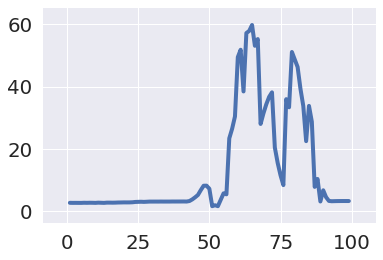

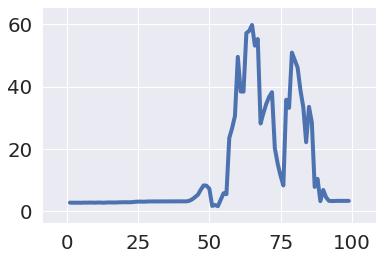

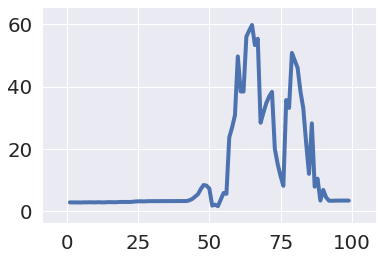

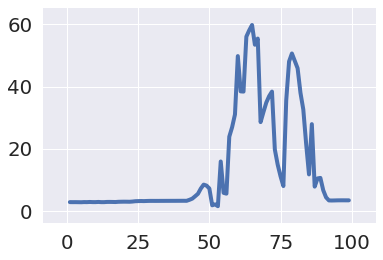

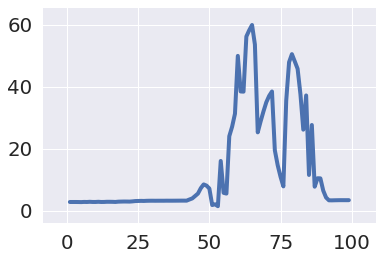

In [18]:
from nuplan.common.actor_state.agent import AgentType
from nuplan.common.actor_state.vehicle_parameters import get_pacifica_parameters
from nuplan.common.actor_state.transform_state import get_ego_polygon, project_distance_to_lat_lon

from shapely.ops import nearest_points
from typing import List, Tuple

"""
Euclidean: L2 distance between the closest points of the two boxes
Longitudinal: L2 distance between centers of two boxes project along ego's heading
    subtracted by half lengths of ego and agent box
Lateral: L2 distance between centers of two boxes project perpendicular to ego's heading
    subtracted by half widths of ego and agent box
"""
def get_ego_agent_relative_distances(ego_state, box, vehicle_parameters) -> Tuple[float, float, float]:
    # Construct Ego Polygon
    ego_polygon = get_ego_polygon(ego_state, vehicle_parameters)

    # Construct Agent Polygon
    agent_polygon = box.geometry # get_box_polygon(box)

    # Shapely computes distance between closest points between two polygons
    p1, p2 = nearest_points(agent_polygon, ego_polygon)
    euclidean_distance = p1.distance(p2)

    # Create a vector from ego to agent
    agent_ego_vector = [ego_state.x - box.center.x, ego_state.y - box.center.y]
    vec_dist = np.linalg.norm(agent_ego_vector)  # type: ignore

    # Get angle the vector from ego to agent makes with x axis
    agent_ego_angle = np.arccos(agent_ego_vector[0] / vec_dist)
    # Get angle ego makes with x axis
    ego_heading = ego_state.heading

    # Get relative angle between ego yaw and agent_ego_vector
    delta_theta = ego_heading - agent_ego_angle

    # Project to get components
    longitudinal_distance, lateral_distance = project_distance_to_lat_lon(vec_dist, delta_theta,
                                                                          vehicle_parameters, box)

    return euclidean_distance, longitudinal_distance, lateral_distance

for INDEX_MAIN in range(5):

    BASE_TIME = b[INDEX_MAIN].get_ego_state_at_iteration(0).time_seconds
    curr_agent = None
    x, y = [], []

    for INDEX in range(1, 100, 1):
        ego_state = b[INDEX_MAIN].get_ego_state_at_iteration(INDEX).center
        tracked_agents = b[INDEX_MAIN].get_tracked_objects_at_iteration(INDEX).tracked_objects.get_agents_of_type(AgentType.VEHICLE)

        in_front = []

        if curr_agent is not None:
            ret = None
            for agent in tracked_agents:
                if agent.token != curr_agent: continue
                _, along, perp = get_ego_agent_relative_distances(ego_state, agent.box, b[INDEX_MAIN].ego_vehicle_parameters)
                ret = along
            if ret is None: curr_agent = None
            else: dist = ret

        if curr_agent is None:
            for agent in tracked_agents:
                _, along, perp = get_ego_agent_relative_distances(ego_state, agent.box, b[INDEX_MAIN].ego_vehicle_parameters)
                if perp <= 0.1: in_front.append([ along, agent.token ])

            if len(in_front) == 0: 
                dist = -1
                continue
            else:
                dist, agent = sorted(in_front, key = lambda x: x[0])[0]
    #             if agent != curr_agent: print("AGENT CHANGED!")
                curr_agent = agent

#         print(b[INDEX_MAIN].get_ego_state_at_iteration(INDEX).time_seconds - BASE_TIME, dist)
        x.append(b[INDEX_MAIN].get_ego_state_at_iteration(INDEX).time_seconds - BASE_TIME)
        y.append(dist)
    plt.plot(x, y)
    plt.show()

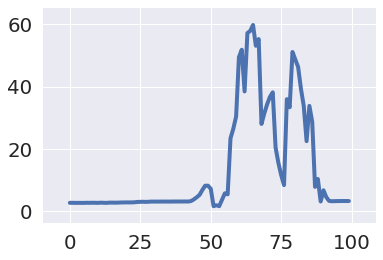

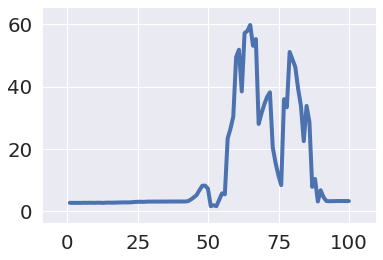

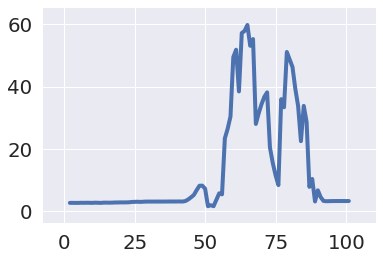

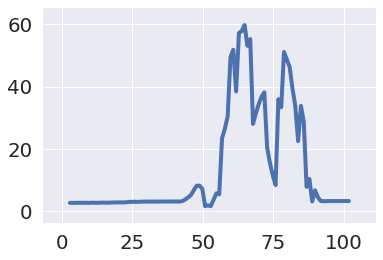

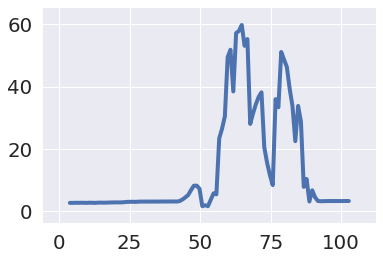

In [17]:
from nuplan.common.actor_state.agent import AgentType
from nuplan.common.actor_state.vehicle_parameters import get_pacifica_parameters
from nuplan.common.actor_state.transform_state import get_ego_polygon, project_distance_to_lat_lon

from shapely.ops import nearest_points
from typing import List, Tuple

"""
Euclidean: L2 distance between the closest points of the two boxes
Longitudinal: L2 distance between centers of two boxes project along ego's heading
    subtracted by half lengths of ego and agent box
Lateral: L2 distance between centers of two boxes project perpendicular to ego's heading
    subtracted by half widths of ego and agent box
"""
def get_ego_agent_relative_distances(ego_state, box, vehicle_parameters) -> Tuple[float, float, float]:
    # Construct Ego Polygon
    ego_polygon = get_ego_polygon(ego_state, vehicle_parameters)

    # Construct Agent Polygon
    agent_polygon = box.geometry # get_box_polygon(box)

    # Shapely computes distance between closest points between two polygons
    p1, p2 = nearest_points(agent_polygon, ego_polygon)
    euclidean_distance = p1.distance(p2)

    # Create a vector from ego to agent
    agent_ego_vector = [ego_state.x - box.center.x, ego_state.y - box.center.y]
    vec_dist = np.linalg.norm(agent_ego_vector)  # type: ignore

    # Get angle the vector from ego to agent makes with x axis
    agent_ego_angle = np.arccos(agent_ego_vector[0] / vec_dist)
    # Get angle ego makes with x axis
    ego_heading = ego_state.heading

    # Get relative angle between ego yaw and agent_ego_vector
    delta_theta = ego_heading - agent_ego_angle

    # Project to get components
    longitudinal_distance, lateral_distance = project_distance_to_lat_lon(vec_dist, delta_theta,
                                                                          vehicle_parameters, box)

    return euclidean_distance, longitudinal_distance, lateral_distance

for INDEX_MAIN in range(5):

    BASE_TIME = b[INDEX_MAIN].get_ego_state_at_iteration(0).time_seconds
    curr_agent = None
    x, y = [], []

    for INDEX in range(0, 2000, 20):
        ego_state = b[INDEX].get_ego_state_at_iteration(INDEX_MAIN).center
        tracked_agents = b[INDEX].get_tracked_objects_at_iteration(INDEX_MAIN).tracked_objects.get_agents_of_type(AgentType.VEHICLE)

        in_front = []

        if curr_agent is not None:
            ret = None
            for agent in tracked_agents:
                if agent.token != curr_agent: continue
                _, along, perp = get_ego_agent_relative_distances(ego_state, agent.box, b[INDEX].ego_vehicle_parameters)
                ret = along
            if ret is None: curr_agent = None
            else: dist = ret

        if curr_agent is None:
            for agent in tracked_agents:
                _, along, perp = get_ego_agent_relative_distances(ego_state, agent.box, b[INDEX].ego_vehicle_parameters)
                if perp <= 0.1: in_front.append([ along, agent.token ])

            if len(in_front) == 0: 
                dist = -1
                continue
            else:
                dist, agent = sorted(in_front, key = lambda x: x[0])[0]
#                 if agent != curr_agent: print("AGENT CHANGED!")
                curr_agent = agent

#         print(b[INDEX].get_ego_state_at_iteration(INDEX_MAIN).time_seconds - BASE_TIME, dist)
        x.append(b[INDEX].get_ego_state_at_iteration(INDEX_MAIN).time_seconds - BASE_TIME)
        y.append(dist)
    plt.plot(x, y)
    plt.show()

In [39]:
INDEX_MAIN = 0
INDEX = 1
ego_state = b[INDEX_MAIN].get_ego_state_at_iteration(INDEX).center
tracked_agents = b[INDEX_MAIN].get_tracked_objects_at_iteration(INDEX).tracked_objects.get_agents_of_type(AgentType.VEHICLE)

print(ego_state)
print(sorted([ i.box.center.heading for i in tracked_agents ]))

StateSE2(x=664430.0558868245, y=3996285.799156263, heading=0.07773276489718277)
[-1.5103453030787115, -1.5099377197615582, -1.4900893791361662, -0.9892469597421587, -0.14654671639387917, -0.11495203777757834, -0.008170416486076748, 0.0013366902299629668, 0.005130219124293678, 0.015517145958087175, 0.02041660341829954, 0.028697873887673975, 0.03956309950657855, 0.04724470899458577, 1.4243663225876917, 1.6190156789135974, 1.629031329313562, 1.6308276059832791, 1.639546028547867, 1.6419117926994105, 1.645175052795679, 1.6453156618928375, 1.6523935480718501, 1.6572171380764553, 1.6577160604944856, 1.6645411153551755, 1.6712942817367216, 3.143086006917957, 3.165473871513142, 3.1992157789378686, 3.2233095687409135, 3.2548459199217756, 4.3243266301300975]
